<a href="https://colab.research.google.com/github/Lyu-Sterkh/Sentiment-analysis/blob/main/Vader%26RoBERTa_on_clean_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import string
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax
import re
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [ ]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_clean = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/clean_data.csv', index_col='Unnamed: 0')
#df_clean.head()

,Score,Text
0,5,bought several vitality canned dog food produc...
1,1,product arrived labeled jumbo salted peanutsth...
2,4,confection around century light pillowy citrus...
3,2,looking secret ingredient robitussin believe f...
4,5,great taffy great price wide assortment yummy ...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/df.csv', index_col='Unnamed: 0')
df = df.drop(columns='Id', axis=1)
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4984 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Score   4984 non-null   int64 
 1   Text    4984 non-null   object
dtypes: int64(1), object(1)
memory usage: 116.8+ KB


In [ ]:
df['Score'].value_counts()

5    3126
4     711
1     467
3     393
2     287
Name: Score, dtype: int64

# Stopwords

In [ ]:
stop_words = ['br', 'href']

In [ ]:
#def df_preprocess(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    text = re.sub('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]', ' ', text)
    text = re.sub('[^A-Za-z]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
df['Text'] = df['Text'].apply(df_preprocess)

In [ ]:
df.head()

,Score,Text
0,5,bought sever vital can dog food product found ...
1,1,product arriv label jumbo salt peanut peanut a...
2,4,confect around centuri light pillowi citrus ge...
3,2,look secret ingredi robitussin believ found go...
4,5,great taffi great price wide assort yummi taff...


In [ ]:
df['Text'][25]

'product receiv advertis site strawberri ounc bag pack'

In [ ]:
df['Text'][30]

'never huge coffe fan howev mother purchas littl machin talk tri latt macciato coffe shop better one like product usual non coffe drinker littl dolch guesto machin super easi use prepar realli good coffe latt cappuccino etc less minut water heat would recommend dolc gusto anyon good price get one'

In [ ]:
df_snowball = df
#df_snowball.to_csv('/content/drive/MyDrive/DS/ВКР/NLP/df_snowball.csv')

# Tweets classification

## VADER 

( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:<br>
Stop words are removed<br>
each word is scored and combined to a total score.

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('Live long and prosper!')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
sia.polarity_scores('burn in hell!')

{'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.7088}

In [ ]:
example1 = df_clean['Text'].iloc[30]
example1

'offer great price great taste thanks amazon selling product staral'

In [ ]:
sia.polarity_scores(example1)

{'neg': 0.0, 'neu': 0.319, 'pos': 0.681, 'compound': 0.9153}

In [ ]:
example2 = df_clean['Text'].iloc[60]
example2

'bag candy online pretty expensive cheaper order compete grocery store good combination favorite candy'

In [ ]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.8442}

In [ ]:
# Run the polarity score on the entire dataset
res_vader = {}
for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    text = row['Text']
    df_id = row['Id']
    res_vader[df_id] = sia.polarity_scores(text)

  0%|          | 0/4984 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res_vader)

In [ ]:
vaders.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
neg,0.0000,0.1290,0.1320,0.0000,0.0000,0.0460,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.1380,0.000,0.1760,0.0460,0.0000,0.1790,0.2840,0.0000
neu,0.5170,0.7620,0.5760,0.8540,0.3690,0.6440,0.5480,0.2870,0.7240,0.5850,...,0.3040,0.7370,0.8040,0.479,0.6310,0.7040,0.6690,0.7160,0.5010,0.5560
pos,0.4830,0.1100,0.2920,0.1460,0.6310,0.3100,0.4520,0.7130,0.2760,0.4150,...,0.6960,0.2630,0.0580,0.521,0.1930,0.2510,0.3310,0.1060,0.2150,0.4440
compound,0.9413,-0.1027,0.8624,0.4404,0.9468,0.9136,0.9463,0.9313,0.6369,0.8176,...,0.9292,0.6908,-0.5106,0.967,0.1331,0.9127,0.9812,-0.5076,-0.6804,0.9891


In [ ]:
vaders = vaders.T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_clean, how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,Unnamed: 0,ProductId,Score,Summary,Text
0,1,0.000,0.517,0.483,0.9413,0,B001E4KFG0,5,Good Quality Dog Food,bought several vitality canned dog food produc...
1,2,0.129,0.762,0.110,-0.1027,1,B00813GRG4,1,Not as Advertised,product arrived labeled jumbo salted peanutsth...
2,3,0.132,0.576,0.292,0.8624,2,B000LQOCH0,4,"""Delight"" says it all",confection around century light pillowy citrus...
3,4,0.000,0.854,0.146,0.4404,3,B000UA0QIQ,2,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,0.000,0.369,0.631,0.9468,4,B006K2ZZ7K,5,Great taffy,great taffy great price wide assortment yummy ...


In [ ]:
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### VADER results visualisation

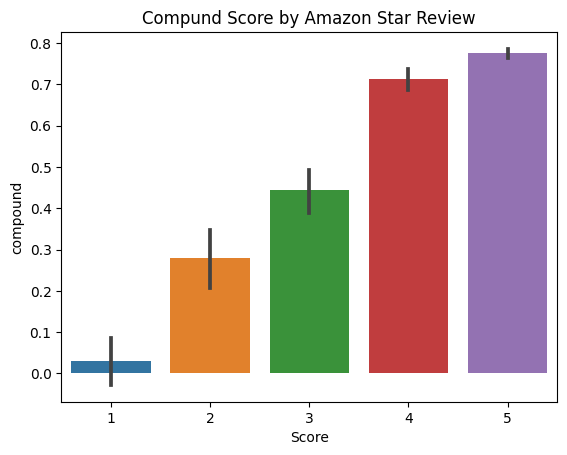

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Compund Score by Amazon Star Review.jpeg')
plt.show()

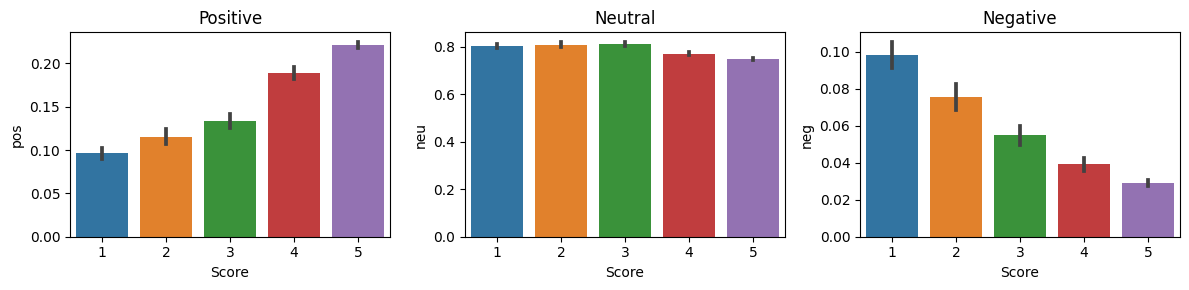

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scores by Amazon Star Review.jpeg')
plt.show()

## Roberta Pretrained Model

Use a model trained of a large corpus of data.

Transformer model accounts for the words but also the context related to other words.

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
example = df_clean['Text'].iloc[0]
example

'bought several vitality canned dog food product found good quality product look like stew processed meat smell better la ador finicky appreciates product better'

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.006078331, 'roberta_neu': 0.07159131, 'roberta_pos': 0.92233044}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res_roberta = {}
for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    try:
        text = row['Text']
        df_id = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res_roberta[df_id] = both
    except RuntimeError:
        print(f'Broke for id {df_id}')

  0%|          | 0/4984 [00:00<?, ?it/s]

Broke for id 540
Broke for id 1321
Broke for id 1498
Broke for id 2248


In [ ]:
results_df = pd.DataFrame(res_roberta)
results_df.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
vader_neg,0.000000,0.12900,0.132000,0.000000,0.000000,0.046000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.138000,0.000000,0.176000,0.046000,0.000000,0.179000,0.28400,0.000000
vader_neu,0.517000,0.76200,0.576000,0.854000,0.369000,0.644000,0.54800,0.287000,0.724000,0.58500,...,0.304000,0.737000,0.804000,0.479000,0.631000,0.704000,0.669000,0.716000,0.50100,0.556000
vader_pos,0.483000,0.11000,0.292000,0.146000,0.631000,0.310000,0.45200,0.713000,0.276000,0.41500,...,0.696000,0.263000,0.058000,0.521000,0.193000,0.251000,0.331000,0.106000,0.21500,0.444000
vader_compound,0.941300,-0.10270,0.862400,0.440400,0.946800,0.913600,0.94630,0.931300,0.636900,0.81760,...,0.929200,0.690800,-0.510600,0.967000,0.133100,0.912700,0.981200,-0.507600,-0.68040,0.989100
roberta_neg,0.006078,0.08729,0.003831,0.005513,0.001966,0.002418,0.00221,0.001913,0.014226,0.00697,...,0.001696,0.011868,0.703758,0.001615,0.450024,0.173189,0.002295,0.143365,0.09091,0.018759


In [ ]:
results_df = results_df.T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df_clean, how='left')

In [ ]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Unnamed: 0,ProductId,Score,Summary,Text
0,1,0.000,0.517,0.483,0.9413,0.006078,0.071591,0.922330,0,B001E4KFG0,5,Good Quality Dog Food,bought several vitality canned dog food produc...
1,2,0.129,0.762,0.110,-0.1027,0.087290,0.848000,0.064710,1,B00813GRG4,1,Not as Advertised,product arrived labeled jumbo salted peanutsth...
2,3,0.132,0.576,0.292,0.8624,0.003831,0.103483,0.892686,2,B000LQOCH0,4,"""Delight"" says it all",confection around century light pillowy citrus...
3,4,0.000,0.854,0.146,0.4404,0.005513,0.342440,0.652047,3,B000UA0QIQ,2,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,0.000,0.369,0.631,0.9468,0.001966,0.012693,0.985340,4,B006K2ZZ7K,5,Great taffy,great taffy great price wide assortment yummy ...


## Compare Scores between models

In [ ]:
results_df.columns.to_list()

['Id',
 'vader_neg',
 'vader_neu',
 'vader_pos',
 'vader_compound',
 'roberta_neg',
 'roberta_neu',
 'roberta_pos',
 'Unnamed: 0',
 'ProductId',
 'Score',
 'Summary',
 'Text']

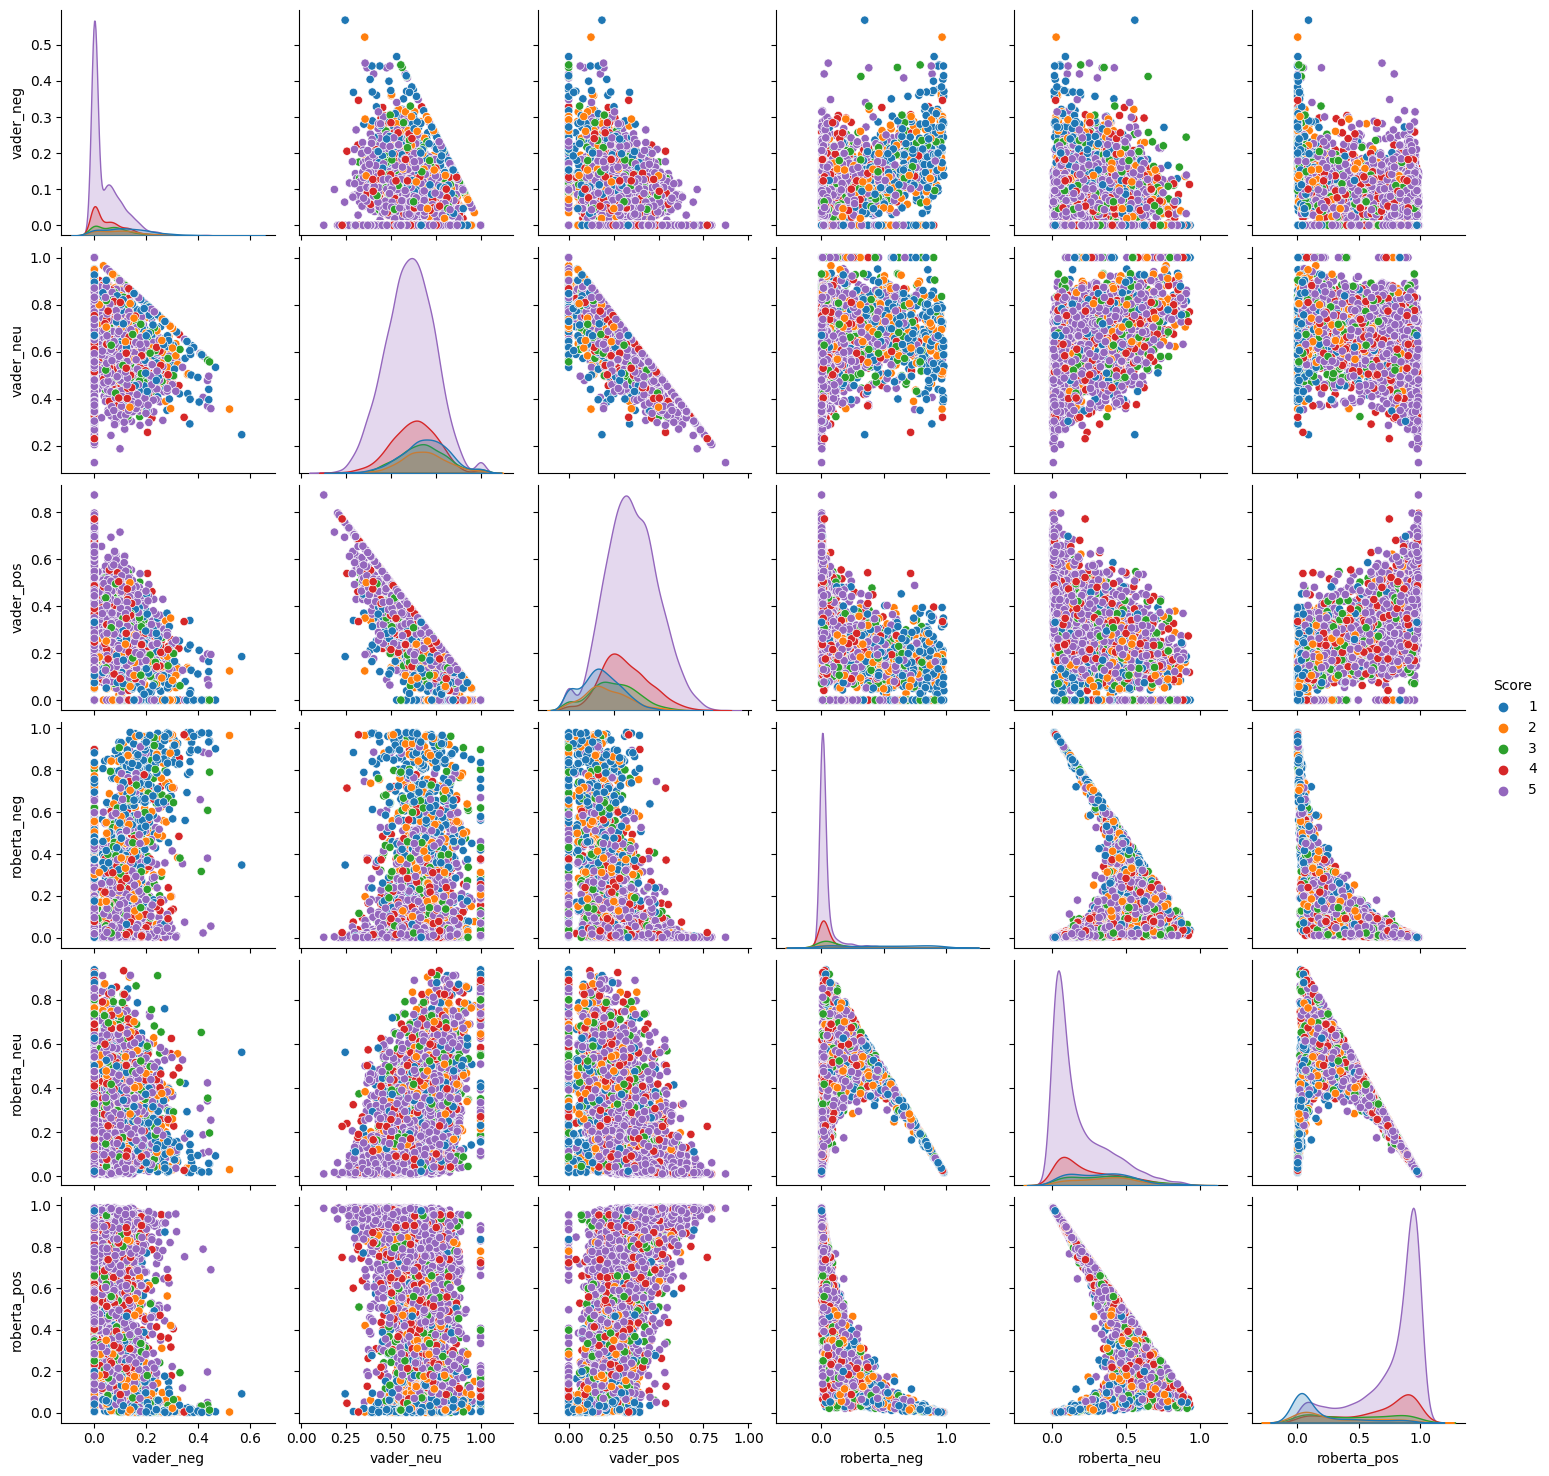

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Vader_Roberta_comparison2.jpeg')
plt.show()

## Loss examples
Lets look at some examples where the model scoring and review score differ the most.

Positive 1-Star and Negative 5-Star Reviews

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'impressed cooky tried first came company one flavor care knew something satisfying could id tried others found many great paleo cookie recipe web site paleo cookbook love friend cooking student neighbor really enjoyed youre looking rock taste bud paleo cooky suggest check recipe chocolate chip cooky flavor cooky made blanched almond flour found gluten free almond flour cookbook make paleo elana amsterdam web site'

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[5]

'second ingredient sugar need say make bisquit mix super easy'